## This is my first attempt to load OPM data into MNE. 

Seems to load fine. A few things to sort:

- Scaling is weird. Does MNE apply some unknown scaling  factor to mags?
- Montage (sensor positions) not applied to raw
- MNE seems to treat montages as EEG electrodes
- How do we input orientation of sensors?
- Epoching?
- SSP is weird





In [3]:
def load_UCL_OPM(raw_name, chan_name, json_file, pos_file):
    # Import the necessary packages
    import numpy as np
    import matplotlib.pyplot as plt
    import mne
    import pandas as pd
    import json

    # Load 1D data from .bin file
    d = np.fromfile(raw_name,'>f4')
    
    print('Data loaded as: ' + str(d.dtype))
    
    # Load tsv channels file
    tsv = pd.read_csv(chan_name,sep='\t')
    
    # Replace the channel types with a
    tsv['type'] = tsv['type'].replace('MEGMAG','mag')
    tsv['type'] = tsv['type'].replace('TRIG','stim')
    tsv['type'] = tsv['type'].replace('REF','ref_meg')
    
    # Replace Flux channels with misc
    tsv.loc[tsv.name.str.contains('Flux'), 'type'] = 'misc'
    
    # Put these into a list
    chans = tsv['name'].values.tolist()
    types = tsv['type'].values.tolist()
    
    # Open the _meg.json and extract the sampling freq
    with open(chan_json) as json_file:
        json_meg = json.load(json_file)

    Fs = json_meg['SamplingFrequency']
    
    # Make a montage
    pos_tsv = pd.read_csv(pos_file,sep='\t')

    dict = {}

    for e in np.arange(0,len(pos_tsv)):
        dict[pos_tsv.name[e]] = np.array([pos_tsv.Px[e]/1000,pos_tsv.Py[e]/1000,pos_tsv.Pz[e]/1000])

    montage_opm = mne.channels.make_dig_montage(ch_pos=dict,coord_frame='mri')
    
    # Create MNE info field
    inf = mne.create_info(chans, Fs, ch_types = types, montage=montage_opm, verbose=None)
    
    # Reshape the 1D data into 2D based on the number of channels present
    d2 = np.reshape(d, [len(chans), int(len(d)/len(chans))],'F')
    
    # Create raw MNE object
    raw = mne.io.RawArray(d2, inf, first_samp=0, copy='auto', verbose=None)
    
    return raw
    

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd
import json
import os.path as op

In [5]:
%matplotlib tk

In [6]:
# Path to data
script_dir      = '/Users/rseymoue/Documents/GitHub/analyse_OPMEG'
data_dir        = '/Volumes/Robert T5/22_09_2020_benchmarking/'
save_dir        = '/Users/rseymoue/Documents/GitHub/opm_benchmarking_feb_2020/'

In [8]:
cd ../

/


In [5]:
cd /Volumes/Robert\ T5/22_09_2020_benchmarking/

/Volumes/Robert T5/22_09_2020_benchmarking


In [116]:
raw_name               = op.join(data_dir, 'sub-NA/', 'ses-001/','meg/','sub-NA_ses-001_task-MMF_run-001_meg.bin')
raw_emptyroom_name     = op.join(data_dir, 'sub-001/', 'ses-001/','meg/','sub-001_ses-001_task-noise_run-001_meg.bin')
chan_name              = op.join(data_dir, 'sub-NA/', 'ses-001/','meg/','sub-NA_ses-001_task-MMF_run-001_channels.tsv')
chan_json              = op.join(data_dir, 'sub-NA/', 'ses-001/','meg/','sub-NA_ses-001_task-MMF_run-001_meg.json')
pos_file               = op.join(data_dir, 'sub-NA/', 'ses-001/','meg/','sub-NA_ses-001_task-MMF_run-001_positions.tsv')


In [117]:
raw       = load_UCL_OPM(raw_name, chan_name, chan_json, pos_file)
raw_noise = load_UCL_OPM(raw_emptyroom_name, chan_name, chan_json, pos_file)
raw_spare = raw

Data loaded as: >f4


<ipython-input-3-660df6972b07>:46: DeprecationWarning: Passing montage to create_info is deprecated and will be removed in 0.21, use raw.set_montage (or epochs.set_montage, etc.) instead
  inf = mne.create_info(chans, Fs, ch_types = types, montage=montage_opm, verbose=None)
<ipython-input-3-660df6972b07>:46: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  inf = mne.create_info(chans, Fs, ch_types = types, montage=montage_opm, verbose=None)


Creating RawArray with float64 data, n_channels=77, n_times=4504140
Current compensation grade : 0
    Range : 0 ... 4504139 =      0.000 ...   750.690 secs
Ready.
Data loaded as: >f4


<ipython-input-3-660df6972b07>:46: DeprecationWarning: Passing montage to create_info is deprecated and will be removed in 0.21, use raw.set_montage (or epochs.set_montage, etc.) instead
  inf = mne.create_info(chans, Fs, ch_types = types, montage=montage_opm, verbose=None)
<ipython-input-3-660df6972b07>:46: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  inf = mne.create_info(chans, Fs, ch_types = types, montage=montage_opm, verbose=None)


Creating RawArray with float64 data, n_channels=77, n_times=1080540
Current compensation grade : 0
    Range : 0 ... 1080539 =      0.000 ...   180.090 secs
Ready.


In [82]:
picks = mne.pick_types(raw.info,'mag')

Effective window size : 10.000 (s)


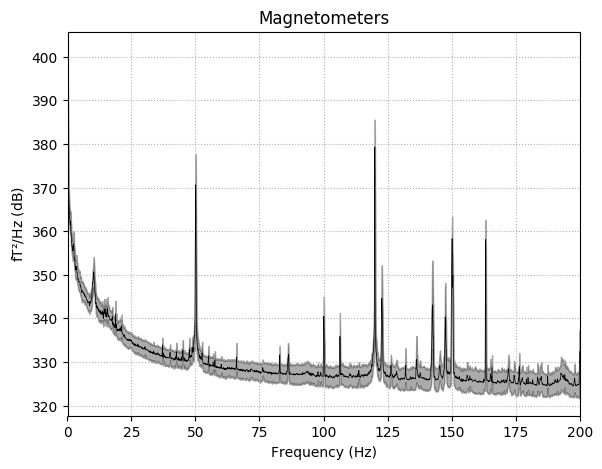

In [14]:
raw.plot_psd(average=True,fmin=0.1,fmax=200,picks=picks,n_fft=60000)

In [18]:
raw = raw.notch_filter(np.arange(50, 251, 50),notch_widths=2)
raw = raw.notch_filter(120,notch_widths=2)
raw = raw.filter(l_freq=2, h_freq=40)


Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 39601 samples (6.600 sec)

Setting up band-stop filter from 1.2e+02 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 118.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 118.25 Hz)
- Upper passband edge: 121.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 121.75 Hz)
- Filter length: 39601 samples (6.600 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 40 Hz

In [38]:
fig = mne.viz.plot_alignment(raw.info, trans=None, dig=False, eeg=False,
                             surfaces=[], meg=['sensors'],
                             coord_frame='meg')
mne.viz.set_3d_view(fig, azimuth=50, elevation=90, distance=0.5)

ERROR:root:Cannot activate multiple GUI eventloops


In [19]:
raw.plot(highpass=2, lowpass=100, remove_dc=True, scalings = 'auto', start=10.0,duration = 60)

TypeError: plot() got an unexpected keyword argument 'picks'

### Events

In [21]:
events = mne.find_events(raw_spare, stim_channel='NI-TRIG',uint_cast=True,min_duration=0.1)

1449 events found
Event IDs: [5]


In [22]:
# Compute epochs
tmin, tmax, event_id = -0.2, 0.5, 5  # take right-hand somato

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=(-0.2, 0), preload=True)

1449 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1449 events and 4201 original time points ...
0 bad epochs dropped


In [23]:
# compute evoked
evoked = epochs.average()

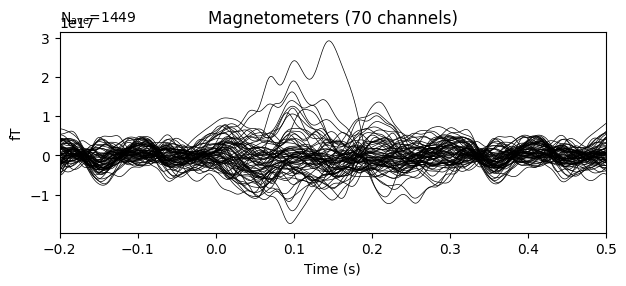

In [24]:
# plot the result
evoked.plot(time_unit='s')

In [25]:
epochs.resample(600)

<Epochs  |   1449 events (all good), -0.2 - 0.498333 sec, baseline [-0.2, 0], ~325.2 MB, data loaded,
 '5': 1449>

In [ ]:
epochs.plot_psd(average=True,fmin=0.1,fmax=50)

### Make a Montage

In [28]:
# Make a montage
pos_tsv = pd.read_csv(pos_file,sep='\t')

dict = {}

for e in np.arange(0,len(pos_tsv)):
    dict[pos_tsv.name[e]] = np.array([pos_tsv.Px[e]/1000,pos_tsv.Py[e]/1000,pos_tsv.Pz[e]/1000])

montage_opm = mne.channels.make_dig_montage(ch_pos=dict,coord_frame='mri')

In [ ]:
montage_opm.dig

In [ ]:
raw.info.set_montage(montage_opm)

In [98]:
raw

<RawArray | 62 x 4504140 (750.7 s), ~2.08 GB, data loaded>

Opening raw data file /Users/rseymoue/MMF_data_raw.fif...
Isotrak not found
    Range : 0 ... 4504139 =      0.000 ...   750.690 secs
Ready.
Current compensation grade : 0


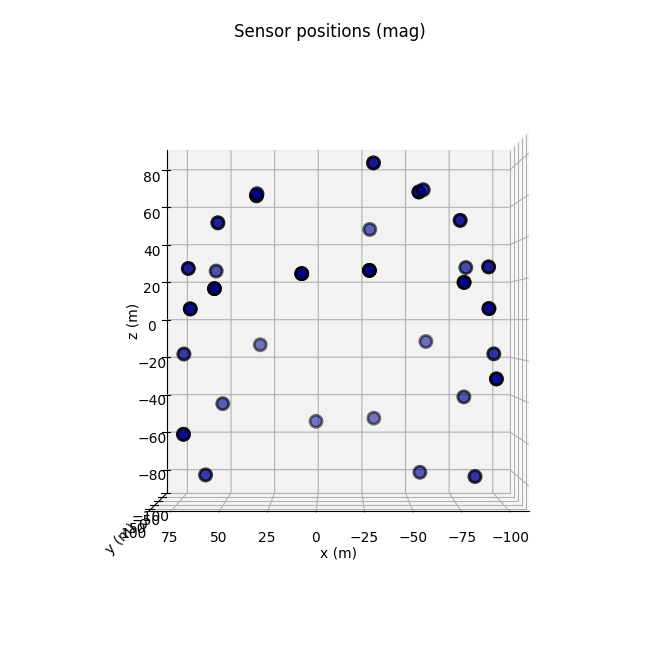

In [100]:
from mne.io import read_raw_fif
raw2 = read_raw_fif('/Users/rseymoue/MMF_data_raw.fif')
raw_mag = raw.pick_types('mag')

raw_mag.info = raw2.info

raw_mag.plot_sensors(kind='3d')

In [112]:
mag_picks = mne.pick_types(raw_mag.info, meg="mag")
other_picks = np.setdiff1d(np.arange(len(raw_mag.ch_names)), mag_picks)
    
for ii in mag_picks:
    raw_mag.info["chs"][ii]["coil_type"] = FIFF.FIFFV_COIL_VV_MAG_T2
orig_types = np.array([ch["coil_type"] for ch in raw.info["chs"]])


NameError: name 'FIFF' is not defined

In [101]:
mne.channels.fix_mag_coil_types(raw_mag.info)

62 of 62 T1/T2 magnetometer types replaced with T3.


In [ ]:
raw_mag.info['chs']

In [120]:
raw_mag_sss = mne.preprocessing.maxwell_filter(raw_mag, extended_proj=ssp1, coord_frame='meg',verbose=True)

TypeError: maxwell_filter() got an unexpected keyword argument 'extended_proj'

In [110]:
raw.info

<Info | 9 non-empty values
 bads: []
 ch_names: A6-TAN, A6-RAD, 1C-TAN, 1C-RAD, A2-TAN, A2-RAD, A9-TAN, A9-RAD, ...
 chs: 62 MAG
 custom_ref_applied: False
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 3000.0 Hz
 meas_date: 1970-01-01 00:00:00 UTC+00:00
 meas_id: 4 items (dict)
 nchan: 62
 projs: []
 sfreq: 6000.0 Hz
>

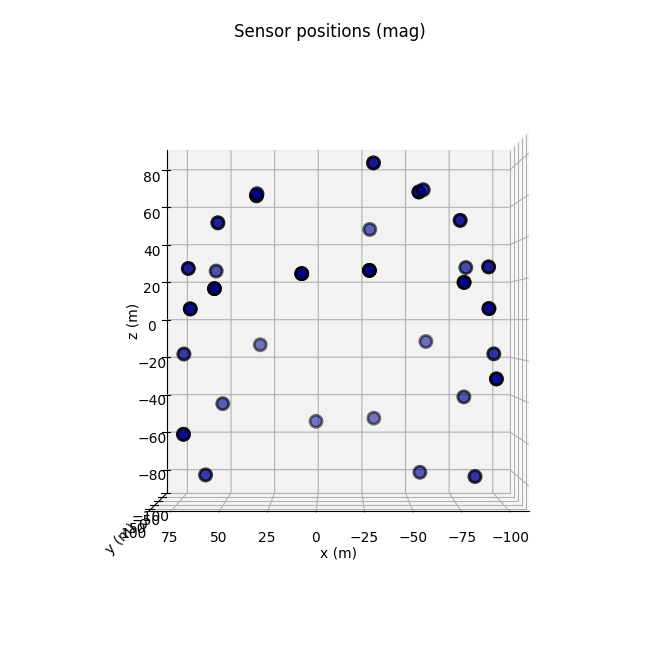

In [118]:
raw_noise_mag = raw_noise.pick_types('mag')

raw_noise_mag.info = raw2.info

raw_noise_mag.plot_sensors(kind='3d')

In [119]:
ssp1 = mne.compute_proj_raw(raw_noise,n_mag=62)

180 matching events found
No baseline correction applied
Not setting metadata
No gradiometers found. Forcing n_grad to 0
Adding projection: axial-Raw-0.000-180.090-PCA-01
Adding projection: axial-Raw-0.000-180.090-PCA-02
Adding projection: axial-Raw-0.000-180.090-PCA-03
Adding projection: axial-Raw-0.000-180.090-PCA-04
Adding projection: axial-Raw-0.000-180.090-PCA-05
Adding projection: axial-Raw-0.000-180.090-PCA-06
Adding projection: axial-Raw-0.000-180.090-PCA-07
Adding projection: axial-Raw-0.000-180.090-PCA-08
Adding projection: axial-Raw-0.000-180.090-PCA-09
Adding projection: axial-Raw-0.000-180.090-PCA-10
Adding projection: axial-Raw-0.000-180.090-PCA-11
Adding projection: axial-Raw-0.000-180.090-PCA-12
Adding projection: axial-Raw-0.000-180.090-PCA-13
Adding projection: axial-Raw-0.000-180.090-PCA-14
Adding projection: axial-Raw-0.000-180.090-PCA-15
Adding projection: axial-Raw-0.000-180.090-PCA-16
Adding projection: axial-Raw-0.000-180.090-PCA-17
Adding projection: axial-Raw-

In [129]:
raw.add_proj(ssp1)

15 projection items deactivated


<RawArray | 32 x 885980 (886.0 s), ~216.4 MB, data loaded>

In [130]:
raw.apply_proj()

Created an SSP operator (subspace dimension = 15)
15 projection items activated
SSP projectors applied...


<RawArray | 32 x 885980 (886.0 s), ~216.4 MB, data loaded>

Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB



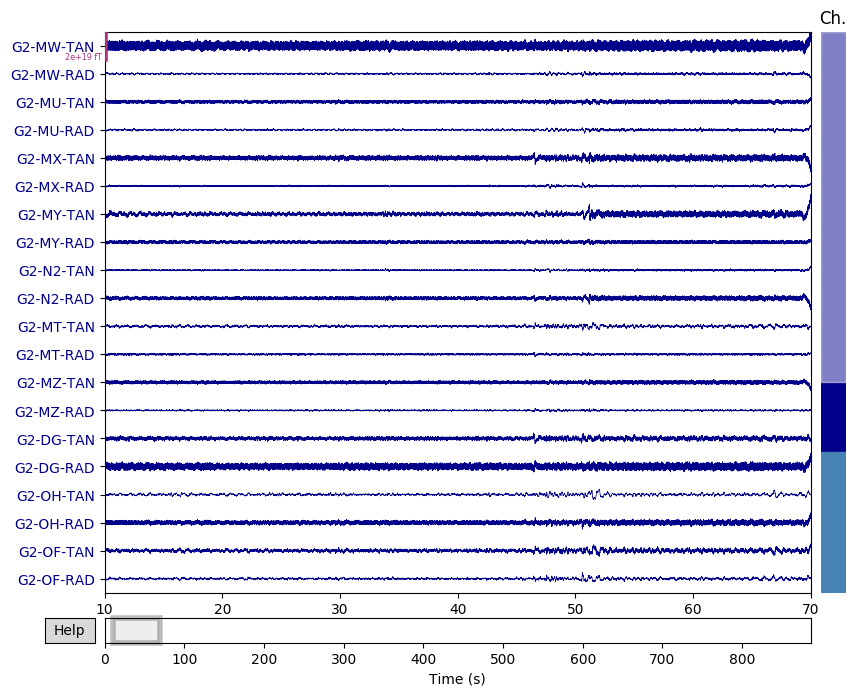

In [136]:
raw.plot(start=10.0,duration = 60, scalings = 1e4, highpass=1, lowpass = 100)

In [ ]:
raw.plot_projs_topomap(ssp1)

Effective window size : 2.048 (s)


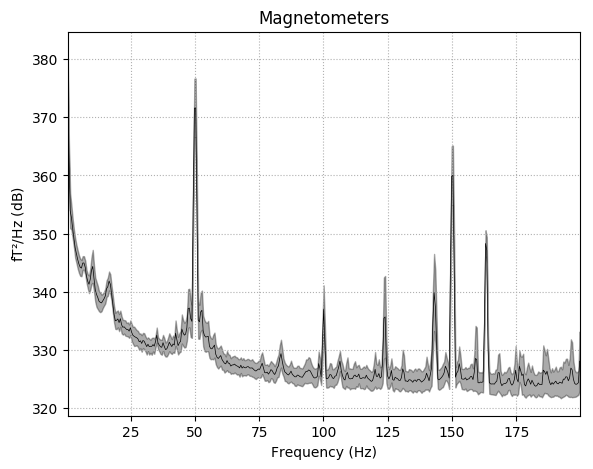

In [133]:
raw_noise.plot_psd(average=True,fmin=0.1,fmax=200)